In [1]:
# Auto reload module
# https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
dataset_dir = '/robin-west/womd_processed/single_agent_subset/validation/processed'
ckpt_path = '/robin-west/VBD/weights/epoch=27.ckpt'
anchor_path = '/robin-west/VBD/vbd/data/cluster_64_center_dict.pkl'

In [3]:
## Import Dependencies
import torch
import numpy as np

import sys
workspace_path = "/robin-west/VBD"
sys.path.append(f"{workspace_path}")
from vbd.model.utils import set_seed
set_seed(0)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
# set tf to cpu only
tf.config.set_visible_devices([], 'GPU')
import jax
jax.config.update('jax_platform_name', 'cpu')

from waymax import dynamics
from waymax.config import EnvironmentConfig, ObjectType
from vbd.waymax_visualization.plotting import plot_state
from vbd.data.data_utils import data_process_scenario, tf_preprocess, tf_postprocess, data_collate_fn
from waymax import dataloader
from waymax.config import DataFormat
import mediapy
import pickle

MAX_NUM_OBJECTS = 32
MAX_POLYLINES = 256
NUM_POINTS_POLYLINE = 30


## Set Environment
env_config = EnvironmentConfig(
    # Ensure that the sim agent can control all valid objects.
    controlled_object=ObjectType.VALID,
    allow_new_objects_after_warmup=False,
    init_steps=11,
    max_num_objects=128,
)

from vbd.sim_agent.waymax_env import WaymaxEnvironment
from vbd.data.waymax_utils import smooth_scenario
dynamics_model = dynamics.StateDynamics()
env = WaymaxEnvironment(
    dynamics_model=dynamics_model,
    config=env_config,
    log_replay = True,
)

# Create Dataset
from vbd.data.dataset import WaymaxTestDataset

dataset = WaymaxTestDataset(
    data_dir = dataset_dir,
    anchor_path = anchor_path,
    max_object=MAX_NUM_OBJECTS,
)
# Load model
from vbd.sim_agent.sim_actor import VBDTest, sample_to_action
print('Load model', ckpt_path)
model = VBDTest.load_from_checkpoint(ckpt_path,map_location=torch.device('cpu'))
_ = model.cuda()
_ = model.eval()

model.reset_agent_length(MAX_NUM_OBJECTS)

Load model /robin-west/VBD/weights/epoch=27.ckpt


In [4]:
def plot_results(init_state, is_controlled, denoiser_output, h=-1, t=-1, video = False, **kwargs):
    if 'history' in denoiser_output:
        # traj_input = denoiser_output['history']['denoiser_output_history']['noised_trajs'][h, 0, ...]
        traj_pred = denoiser_output['history']['denoiser_output_history']['denoised_trajs'][h, 0, ...] # [A,T,D]
    else:
        # traj_input = denoiser_output['noised_trajs'][0, ...].detach().cpu().numpy()
        traj_pred = denoiser_output['denoised_trajs'][0, ...].detach().cpu().numpy()
    
    state_logs = [init_state]
    current_state = init_state
    for i in range(init_state.remaining_timesteps):
        action_sample = traj_pred[:, i, :]
        action = sample_to_action(action_sample, is_controlled)
        current_state = env.step_sim_agent(current_state, [action])
        state_logs.append(current_state)

    mediapy.show_image(plot_state(state_logs[t], **kwargs))

In [5]:
dataset[0].keys()

dict_keys(['agents_history', 'agents_interested', 'agents_type', 'agents_future', 'traffic_light_points', 'polylines', 'polylines_valid', 'relations', 'agents_id', 'anchors'])

In [6]:
dataset[0]['agents_interested']

array([10, 10, 10,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)

7


""

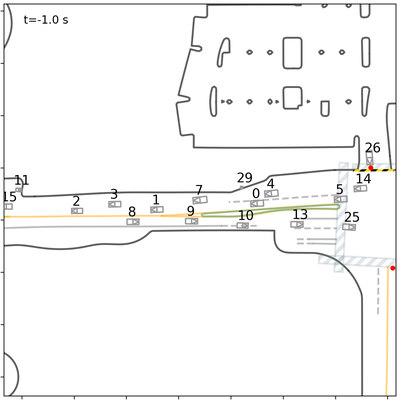

""

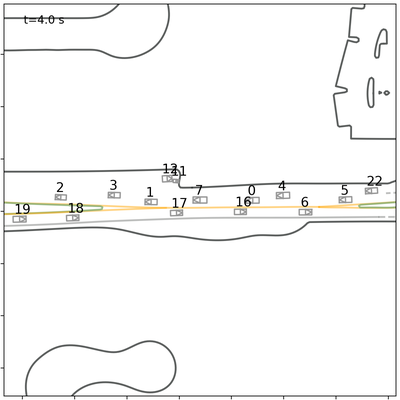

""

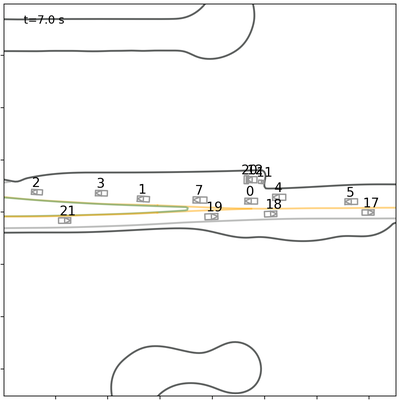

In [10]:
scenario_id, scenario, data = dataset.get_scenario_by_id('86b4b920ba9fb858')
sdc_id = np.where(scenario.object_metadata.is_sdc)[0][0]
sdc_id_in_processed = np.where(data["agents_id"]==sdc_id)[0][0]
print(sdc_id_in_processed)
scenario.sim_trajectory = scenario.log_trajectory
scenario.timestep=0
mediapy.show_image(plot_state(scenario))
scenario.timestep=50
mediapy.show_image(plot_state(scenario))
scenario.timestep=80
mediapy.show_image(plot_state(scenario))

In [11]:
scenario.log_trajectory.yaw[7, 10:50]

Array([-3.0391128, -3.0404806, -3.0421467, -3.0443876, -3.0467215,
       -3.0491354, -3.0516331, -3.0543935, -3.0577347, -3.0612667,
       -3.0645154, -3.0682638, -3.072038 , -3.075963 , -3.080055 ,
       -3.083826 , -3.0883145, -3.09266  , -3.0967338, -3.100679 ,
       -3.1042104, -3.1074586, -3.1103227, -3.1125019, -3.1146271,
       -3.1164558, -3.1188376, -3.1218934, -3.124854 , -3.1275518,
       -3.129874 , -3.1321783, -3.1345704, -3.136872 , -3.138598 ,
       -3.1401348, -3.1413848,  3.1407397,  3.1401703,  3.1395009],      dtype=float32)

In [15]:
def wrap_angle(angle):
    """
    Wrap the angle to [-pi, pi].

    Args:
        angle (torch.Tensor): Angle tensor.

    Returns:
        torch.Tensor: Wrapped angle.

    """
    # return torch.atan2(torch.sin(angle), torch.cos(angle))
    return (angle + torch.pi) % (2 * torch.pi) - torch.pi
wrap_angle(6.16)*10 / 40

-0.030796326794896522

In [9]:
replan_freq=80 # Roll out every X steps 80 means openloop
model.early_stop=0 # Stop Diffusion Early From 100 to X
model.skip = 1 # Skip Alpha 
model.reward_func = None

# Reset the environment
init_state = env.reset(scenario)

current_state = init_state
sample = dataset.process_scenario(
  init_state,
  current_index=init_state.timestep,
  use_log=False
)
is_controlled = sample['agents_interested']>0
selected_agents = sample['agents_id'][is_controlled]

# Update object meta data
print(selected_agents)

state_logs = [current_state]

for i in range(current_state.remaining_timesteps):
    t = i % replan_freq
    if t == 0:
        print("Replan at ", current_state.timestep)
        sample = dataset.process_scenario(
          current_state, 
          current_index = current_state.timestep,
          use_log=False,
          selected_agents=selected_agents, # override the agent selection by distance to the ego
        )
        batch = dataset.__collate_fn__([sample])
        pred = model.sample_denoiser(batch)
        traj_pred = pred['denoised_trajs'].cpu().numpy()[0]

    action_sample = traj_pred[:, t, :]
    action = sample_to_action(action_sample, is_controlled, agents_id=selected_agents)
    current_state = env.step_sim_agent(current_state, [action])
    state_logs.append(current_state)
    break

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
Replan at  10


Diffusion: 100%|██████████| 50/50 [00:03<00:00, 16.01it/s]


""

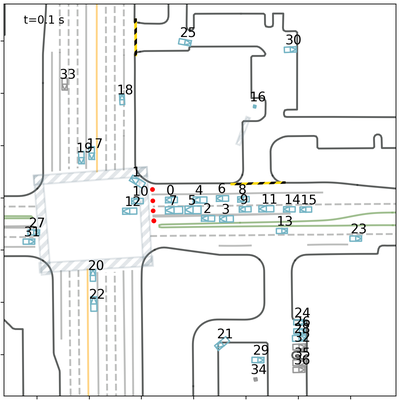

In [11]:
mediapy.show_image(plot_state(current_state))

In [33]:
init_state = env.reset(scenario)

sample = dataset.process_scenario(
  init_state,
  current_index=init_state.timestep,
  use_log=False
)
batch = dataset.__collate_fn__([sample]*3)
pred = model.sample_denoiser(batch)

Diffusion: 100%|██████████| 50/50 [00:03<00:00, 14.66it/s]


In [34]:
pred['denoised_trajs'].cpu().numpy().shape

(3, 32, 80, 5)

In [35]:
init_state

SimulatorState(sim_trajectory=Trajectory(x=Array([[ 5.9336953e+03,  5.9332051e+03,  5.9327432e+03, ...,
        -1.0000000e+00, -1.0000000e+00, -1.0000000e+00],
       [ 5.8780947e+03,  5.8781436e+03,  5.8782456e+03, ...,
        -1.0000000e+00, -1.0000000e+00, -1.0000000e+00],
       [ 5.8521787e+03,  5.8521870e+03,  5.8521880e+03, ...,
        -1.0000000e+00, -1.0000000e+00, -1.0000000e+00],
       ...,
       [-1.0000000e+00, -1.0000000e+00, -1.0000000e+00, ...,
        -1.0000000e+00, -1.0000000e+00, -1.0000000e+00],
       [-1.0000000e+00, -1.0000000e+00, -1.0000000e+00, ...,
        -1.0000000e+00, -1.0000000e+00, -1.0000000e+00],
       [-1.0000000e+00, -1.0000000e+00, -1.0000000e+00, ...,
        -1.0000000e+00, -1.0000000e+00, -1.0000000e+00]], dtype=float32), y=Array([[-3.0921885e+03, -3.0925840e+03, -3.0929580e+03, ...,
        -1.0000000e+00, -1.0000000e+00, -1.0000000e+00],
       [-3.1204814e+03, -3.1205549e+03, -3.1206841e+03, ...,
        -1.0000000e+00, -1.0000000e+00,